# Sangkak AI Challenge: POS tasks
-------------------------------------------------------

- **Author**: Elvis MBONING (NTeALan Research and Development Team)
- **Session**: septembre 2023

----------------------------------------------------------------

In this notebook, we try to train differents models.

We want to train these hypothesis for CRF_suite and Xgboost model:

- impact of features normalization to the model classification
- impact of features regulatization to the model classification
- impact of choice of classification algorithm to the model classification
- impact of data augmentation based on position (imbalence classes) to the model classification
- impact of data augmentation based on features (imbalence classes) to the model classification



# 1. Impact of features normalization to the model classification


### 1.1. Case of Xgboost model

In [ ]:
# Install python packages dependencies (if not already installed)
# version=xgboost-1.7.6
!pip3 install xgboost dython  -U

In [15]:
import pandas as pd
from pathlib import Path
import xgboost as xgb

from sangkak_estimators import SangkakPosProjetReader, SangkakPosFeaturisation

# - Read and format project datasets

In [16]:
# Get path of test data 
language = 'bbj'
bbj_pos_path   = Path(f'../data_source/masakhane-pos/data/{language}')
train_data_path = bbj_pos_path / 'train.txt'
dev_data_path = bbj_pos_path / 'dev.txt'
test_data_path = bbj_pos_path / 'test.txt'

# read data from source with sklearn estimator
reader_estimator = SangkakPosProjetReader()
list_train_data, pd_train_data = reader_estimator.fit(train_data_path).transform_analysis(augment=True)
list_dev_data, pd_dev_data = reader_estimator.fit(dev_data_path).transform_analysis(augment=True)
list_test_data, pd_test_data = reader_estimator.fit(test_data_path).transform_analysis(augment=True)

pd_train_data

,sentence_id,word,tags
0,1,Mwɔ̌ʼ,NOUN
1,1,pfʉ́tə́,VERB
2,1,nə́,ADP
3,1,mwâsi,NOUN
4,1,máp,DET
...,...,...,...
210456,11131,Nəmo,NOUN
210457,11131,Ntamtə,NOUN
210458,11131,Guŋ,NOUN
210459,11131,áá,DET


# - Preprocess and features engineering

In [ ]:
feature_estimator = SangkakPosFeaturisation()
feature_estimator.fit([])

Xtrain = feature_estimator.transform(list_train_data)
Xdev  = feature_estimator.transform(list_dev_data)
Xtest = feature_estimator.transform(list_test_data)

ytrain = feature_estimator.transform(list_train_data, label=True)
ydev   = feature_estimator.transform(list_dev_data, label=True)
ytest  = feature_estimator.transform(list_test_data, label=True)

Xtrain[0]

In [ ]:
features_types = {
    "categorical_features": [
        'word.letters',
        'word',
        'word.tones',
        'word.normalized',
        'word.lower()',
        'word.prefix',
        'word.root',
        '-1:word',
        #'-1:word.tag',
        '-1:word.normalized',
        '-1:word.lower()',
        '-1:word.prefix',
        '-1:word.root',
        '-1:word.letters',
        '+1:word.letters',
        '+1:word.prefix',
        '+1:word.root',
        '+1:word',
        '+1:word.lower()',
        #'+1:word.tag',
        '+1:word.normalized'
    ],
    "numerical_features": [
        'bias',
        'word.position',
        'word.have_tone',
        'word.ispunctuation',
        'word.isdigit()',
        'word.EOS',
        'word.BOS',
        'word.start_with_capital',
        'word.has_hyphen',
        '-1:word.position',
        '-1:word.start_with_capital',
        '-1:len(word-1)',
        '+1:word.position',
        '+1:word.start_with_capital',
        '+1:len(word+1)',
        '+1:word.isdigit()',
        '+1:word.ispunctuation',
        '+1:word.BOS',
        '+1:word.EOS',
        '-1:word.isdigit()',
        '-1:word.ispunctuation',
        '-1:word.BOS',
        '-1:word.EOS'
    ]
}

xgb_df_train = feature_estimator.transform_to_sagemaker_format(
    Xtrain, ytrain,
    normalize=features_types
)
xgb_df_dev = feature_estimator.transform_to_sagemaker_format(
    Xdev, ydev, 
    label='dev',
    normalize=features_types
)
xgb_df_test = feature_estimator.transform_to_sagemaker_format(
    Xtest, ytest, 
    label='test',
    normalize=features_types
)

In [ ]:
import joblib
from datetime import datetime

project = "sangkak-09-2023"
build_date = str(datetime.now()).split(' ')[0]

joblib.dump({
    "xgb_df_train": xgb_df_train, 
    "xgb_df_dev": xgb_df_dev,
    "xgb_df_test": xgb_df_test
}, f'preprocessing/sangkak_input_augment_xgb_df_data_{language}_{build_date}.joblib')


In [17]:
import joblib
from datetime import datetime

project = 'preprocessing/sangkak_input_augment_xgb_df_data_bbj_2023-09-21.joblib'
with open(project, 'rb') as f:
    data = joblib.load(f)
    xgb_df_train = data['xgb_df_train'] 
    xgb_df_dev  = data['xgb_df_dev'] 
    xgb_df_test = data['xgb_df_test'] 


In [ ]:
all_data = pd.concat([xgb_df_train, xgb_df_dev, xgb_df_test], 
                     axis=0, ignore_index=True)
all_data

mystring = "Welcome"
mybytes = mystring.encode('utf-8')
myint = int.from_bytes(mybytes, 'little')
print(myint)
recoveredbytes = myint.to_bytes((myint.bit_length() + 7) // 8, 'little')
recoveredstring = recoveredbytes.decode('utf-8')
print(recoveredstring)

In [ ]:
import random

def string_int_transform(r):
    mybytes = r.encode('utf-8')
    myint = int.from_bytes(mybytes, 'little')
    return myint

all_ref_data, all_labels = {}, {}

def apply_ref_transform(r):
    global all_ref_data
    if r not in all_ref_data: 
        ref = random.randint(-700000, -100)
        all_ref_data[r] = ref
        return ref
    else: return all_ref_data[r]

def apply_label_transform(r):
    global all_labels
    if r not in all_labels: 
        ref = random.randint(0, 15)
        all_labels[r] = ref
        return ref
    else: return all_labels[r]

i = 0
for x in all_data['labels']:
    if x not in all_labels:
        all_labels[x] = i
        i += 1

all_data_parse = all_data.copy()

all_data_parse['labels'] = all_data['labels'].map(all_labels).astype("int")
all_data_parse['word'] = all_data['word'].apply(apply_ref_transform).astype("int")
all_data_parse['word.tones'] = all_data['word.tones'].apply(apply_ref_transform).astype("int")
all_data_parse['word.normalized'] = all_data['word.normalized'].apply(apply_ref_transform).astype("int")
all_data_parse['word.lower()'] = all_data['word.lower()'].apply(apply_ref_transform).astype("int")
all_data_parse['word.prefix'] = all_data['word.prefix'].apply(apply_ref_transform).astype("int")
all_data_parse['word.root'] = all_data['word.root'].apply(apply_ref_transform).astype("int")
all_data_parse['-1:word'] = all_data['-1:word'].apply(apply_ref_transform).astype("int")
#all_data_parse['-1:word.tag'] = all_data['-1:word.tag'].apply(apply_ref_transform).astype("int")
all_data_parse['-1:word.normalized'] = all_data['-1:word.normalized'].apply(apply_ref_transform).astype("int")
all_data_parse['-1:word.lower()'] = all_data['-1:word.lower()'].apply(apply_ref_transform).astype("int")
all_data_parse['+1:word'] = all_data['+1:word'].apply(apply_ref_transform).astype("int")
all_data_parse['+1:word.lower()'] = all_data['+1:word.lower()'].apply(apply_ref_transform).astype("int")
#all_data_parse['+1:word.tag'] = all_data['+1:word.tag'].apply(apply_ref_transform).astype("int")
all_data_parse['+1:word.normalized'] = all_data['+1:word.normalized'].apply(apply_ref_transform).astype("int")
all_data_parse['+1:word.prefix'] = all_data['+1:word.prefix'].apply(apply_ref_transform).astype("int")
all_data_parse['+1:word.root'] = all_data['+1:word.root'].apply(apply_ref_transform).astype("int")
all_data_parse['-1:word.prefix'] = all_data['-1:word.prefix'].apply(apply_ref_transform).astype("int")
all_data_parse['-1:word.root'] = all_data['-1:word.root'].apply(apply_ref_transform).astype("int")
all_data_parse['+1:word.letters'] = all_data['+1:word.letters'].apply(apply_ref_transform).astype("int")
all_data_parse['-1:word.letters'] = all_data['-1:word.letters'].apply(apply_ref_transform).astype("int")
all_data_parse['word.letters'] = all_data['word.letters'].apply(apply_ref_transform).astype("int")

# all_data_parse = all_data_parse.astype(int)

all_data_parse.dtypes

In [ ]:
# remove unused / non performants variables
remove_unused_features = ['+1:word.isdigit()', '+1:word.ispunctuation', '-1:word.EOS',
        '+1:word.BOS', 'word.has_hyphen', '+1:word.EOS', '-1:word.BOS',
        '+1:word.EOS', '-1:word.isdigit()', '+1:word.BOS', 
        '-1:word.ispunctuation', '-1:word.BOS', '+1:word.normalized',
        '-1:word.EOS', '-1:word.tag', '+1:word.tag', 
        '-1:word.start_with_capital','+1:word.start_with_capital']
for x in remove_unused_features:
    try: del all_data_parse[x]
    except: print("-- fail to removed: %s" %x)


## - check correlation between all variables in dataset

In [ ]:
from dython.nominal import associations

# check correlation between all variables in dataset
associations(all_data_parse, nom_nom_assoc='theil', figsize=(15, 15))

# - Preprocess data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import type_of_target

xgb_X_train, xgb_X_test, xgb_y_train, xgb_y_test = train_test_split(
    all_data_parse.drop('labels', axis=1).copy(),
    all_data_parse['labels'].copy(),
    test_size=0.2, random_state=None, shuffle=True
)

xgb_X_train, xgb_X_dev, xgb_y_train, xgb_y_dev = train_test_split(
    xgb_X_train, xgb_y_train, test_size=0.25, 
    random_state=None, shuffle=True
)

num_class = len(list(set(all_data_parse['labels'])))
print("Number of classes: %s" %num_class)

print("Type of target of ytrain data set: %s" %type_of_target(xgb_y_train))
print("Type of target of ytest data set: %s\n" %type_of_target(xgb_y_test))

len_data = len(all_data_parse.index)

def f_len(data):
    l = len(data)
    percent = l*100/len_data
    return {'l':l, 'p':int(percent)}

print("- len of Xtrain data set: {l} ({p}%)".format(**f_len(xgb_X_train)))
print("- len of Xtest data set: {l} ({p}%)".format(**f_len(xgb_X_test)))
print("- len of Xdev data set: {l} ({p}%)".format(**f_len(xgb_X_dev)))
print("len of ytrain data set: {l} ({p}%)".format(**f_len(xgb_y_train)))
print("len of ytest data set: {l} ({p}%)".format(**f_len(xgb_y_test)))
print("len of ydev data set: {l} ({p}%)".format(**f_len(xgb_y_dev)))

# Detecting outliers in data

In [ ]:
!pip install pyod

In [ ]:
from pyod.models.iforest import IForest
from pyod.models.knn import KNN   # kNN detector

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize, data_visualize

In [ ]:
data_visualize(xgb_X_train[:5], xgb_y_train[:5])

In [ ]:
# train IForest detector
clf_name = 'KNN'
clf = KNN()
clf.fit(xgb_X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(xgb_X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(xgb_X_test)  # outlier scores

print(y_test_pred, y_test_scores)

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, xgb_y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, xgb_y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)

# visualize the results
visualize(clf_name, xgb_X_train, xgb_y_train, 
            xgb_X_test, xgb_y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=False)

# - Find the most relevant features in PCA reduction components

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt # visualization library to support seaborn
%matplotlib inline

In [ ]:
numericalDF = xgb_df_train[[
    'labels',
    'word.has_hyphen',
    'word.have_tone',
    'word.ispunctuation',
    'word.isdigit()'
]].copy()
sns.set_style('whitegrid')
sns.pairplot(numericalDF, hue='labels', height=3)
plt.show()

In [ ]:
import numpy as np

"""
Crédit: https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

PCA, as I understand it, identifies the features with the greatest 
variance in a dataset, and can then use this quality of the dataset to create a 
smaller dataset with a minimal loss of descriptive power.
"""

model = PCA(n_components=15).fit(xgb_X_train)
X_pc = model.transform(xgb_X_train)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [all_features[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_feat = pd.DataFrame(sorted(dic.items()))
df_feat

# - Build sklearn pipeline for xgboost model


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

# Compute weights by class for unbalanced datasets
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [ ]:
optimised_labels_weights = compute_sample_weight(
    class_weight='balanced',
    y=xgb_y_train
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("pca", PCA(n_components=18))
    ]
)

numerical_features, categorical_features = [], []
all_features = [x for x in all_data_parse.keys() if x != "labels"]
print(all_features)

for x in all_features:
    if x in features_types['numerical_features']:
        numerical_features.append(x)
for x in all_features:
    if x in features_types['categorical_features']:
        categorical_features.append(x)

print(len(numerical_features), len(categorical_features), len(all_features))

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numerical_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

print(optimised_labels_weights)

# - Train Xgboost model

In [19]:
optimised_labels_weights = compute_sample_weight(
    class_weight='balanced',
    y=xgb_y_train
)

# for overfitting, check: 
# - first: max_depth, min_child_weight and gamma
# - second: subsample, colsample_bytree
#           - reduice eta and increase num_round

# for imabalenced dataset
# - scale_pos_weight (AUC metrics)
# - max_delta_step
xgb_clf = xgb.XGBClassifier(
            objective='multi:softmax', 
            num_class=num_class,
            early_stopping_rounds=10, # use only for XGBClassifier
            eval_metric=['merror','mlogloss'], 
            seed=42, verbosity=1, 
            base_score=None, #The initial prediction score of all instances, global bias
            booster='gbtree',
            gamma=0, 
            importance_type='weight', 
            learning_rate=0.1, 
            # max_bin=250, # Increasing this number improves the optimality of splits at the cost of higher computation time.
            max_delta_step=1.0, # Imbalanced: predicting the right probability
            max_depth=0, # non limit in number of tree => use max RAM
            n_estimators=10060,
            n_jobs=1, 
            nthread=5, 
            random_state=0, 
            # save_period=20, # The period to save the model
            reg_alpha=0, # L1 regularization
            reg_lambda=1.8, # L2 regularization
            scale_pos_weight=1.5, # Imbalanced: Balance the positive and negative weights
            silent=None, 
            # updater="sync", # synchronizes trees in all distributed nodes.
            # grow_policy="lossguide", # Controls a way new nodes are added to the tree.
            # subsample=0.8, # XGBoost would randomly sample half of the training data prior to growing trees
            tree_method="hist" # The tree construction algorithm used in XGBoost
)

# dir(pipe.named_steps['preprocessor'].transformers[1]),
# pipe.named_steps['preprocessor'].transformers[1][1].named_steps['pca']


In [20]:
"""
pipe = Pipeline(
            steps=[
                #("preprocessor", preprocessor),
                ("xgboost", xgb_clf)
            ]
        )
pipe.fit(xgb_X_train.value, xgb_y_train.value, 
         xgboost__verbose=1,
         xgboost__sample_weight=optimised_labels_weights, 
         xgboost__eval_set=[(xgb_X_train, xgb_y_train)])
"""
optimised_labels_weights = compute_sample_weight(
    class_weight='balanced',
    y=xgb_y_train
)

xgb_clf.fit(xgb_X_train, xgb_y_train,
            verbose=1, # set to 1 to see xgb training round intermediate results
            sample_weight=optimised_labels_weights, 
            eval_set=[(xgb_X_train, xgb_y_train), (xgb_X_dev, xgb_y_dev)])

[20:29:41] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-merror:0.25520	validation_0-mlogloss:2.64022	validation_1-merror:0.26141	validation_1-mlogloss:2.64145
[1]	validation_0-merror:0.20556	validation_0-mlogloss:2.50938	validation_1-merror:0.21471	validation_1-mlogloss:2.51200
[2]	validation_0-merror:0.17865	validation_0-mlogloss:2.38022	validation_1-merror:0.18847	validation_1-mlogloss:2.38425
[3]	validation_0-merror:0.15111	validation_0-mlogloss:2.25295	validation_1-merror:0.16226	validation_1-mlogloss:2.25852
[4]	validation_0-merror:0.13494	validation_0-mlogloss:2.12800	validation_1-merror:0.14799	validation_1-mlogloss:2.13516
[5]	validation_0-merror:0.12125	validation_0-mlogloss:2.00536	validation_1-merror:0.13427	validation_1-mlogloss:2.01431
[6]	validation_0-merror:0.11351	validation_0-mlogloss:1.88544	validation_1-merror:0.12661	validation_1-mlogloss:1.89620
[7]	validation_0-merror:0.09958	validation_0-mlogloss:1.76804	vali

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type='weight', interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1.0, max_depth=0,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=10060, n_jobs=1,
              nthread=5, num_class=16, num_parallel_tree=None, ...)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5)

fold_no = 1

train_split = all_data_parse.drop('labels', axis=1).copy()
test_split = all_data_parse['labels'].copy()

for train_index, test_index in skf.split(train_split, test_split):
    print('Fold', str(fold_no),'')
    train = all_data_parse.loc[train_index,:]
    test = all_data_parse.loc[test_index,:]
    print('Test', str(test))
    X_train = train[all_features]
    y_train = train[['labels']]
    print('X_train', str(X_train))
    X_test = test[all_features]
    y_test = test[['labels']]
    xgb_clf.fit(X_train, y_train,
         verbose=1,
         sample_weight=optimised_labels_weights, 
         eval_set=[(X_train, y_train)])
    predictions = xgb_clf.predict(X_test)
    print('Fold',str(fold_no),'Accuracy:', f1_score(y_test, predictions))

    fold_no += 1

# - Hyperparameters tuning

In [ ]:
gridParams = { 
    'learning_rate': [0.005,0.1,0.03,1],
    'n_estimators': [60],
    'num_leaves': [16,32,64], 
    'random_state' : [501],
    'num_boost_round' : [3000],
    'colsample_bytree' : [0.65,0.66,0.3],
    'scale_pos_weight': [1, 1.5,2],
    'subsample' : [0.7,0.75,0.5],
    'reg_alpha' : [1,1.2,0],
    'reg_lambda' : [1,1.2,1.4], 
    'max_bin': [250,300,320,200],
    'importance_type': ['weight','gain']
}
g_lgbm = GridSearchCV(estimator=xgb_clf, param_grid=gridParams, n_jobs=4, 
                      cv=2, verbose=1, error_score='raise')

lgb_model = g_lgbm.fit(xgb_X_train, xgb_y_train, 
                       verbose=1, # set to 1 to see xgb training round intermediate results
                       sample_weight=optimised_labels_weights, 
                       eval_set=(xgb_X_dev, xgb_y_dev))


# - Evaluate model performance

In [ ]:
score = xgb_clf.score(xgb_X_train, xgb_y_train) 
print("Training score: ", score)


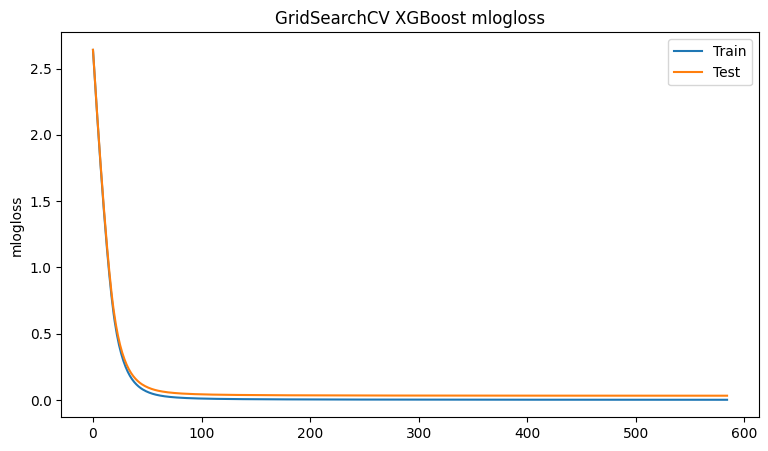

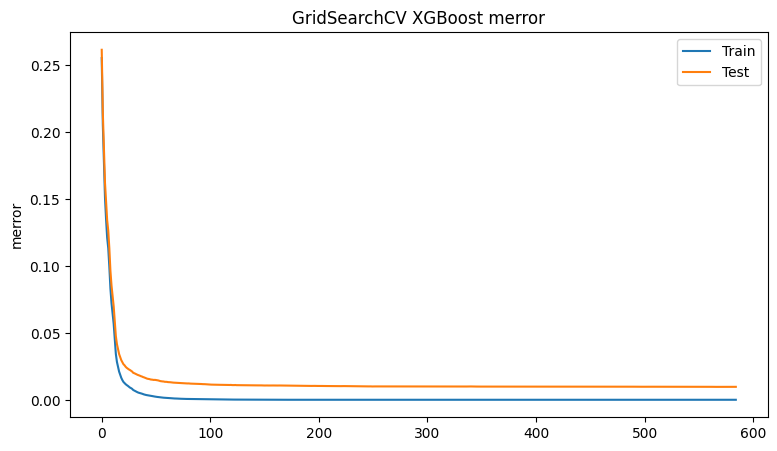

In [21]:
import matplotlib.pyplot as plt
# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()


In [27]:
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.5 MB/s eta 0:00:0000:010:01



------------------ Confusion Matrix -----------------



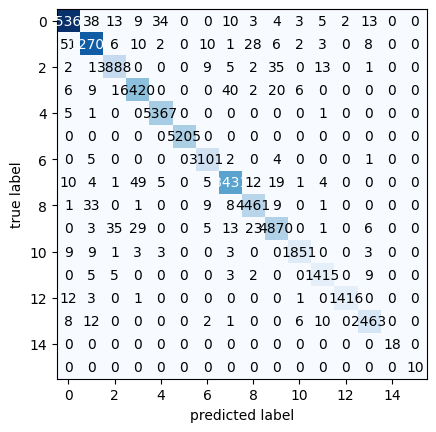


--------------------- Key Metrics --------------------

Accuracy: 0.99
Balanced Accuracy: 0.99

F-score macro: 0.99
F-score micro: 0.99

--------------- Classification Report ---------------

{'NOUN': 0, 'VERB': 1, 'ADP': 2, 'DET': 3, 'PROPN': 4, 'PUNCT': 5, 'SCONJ': 6, 'PRON': 7, 'AUX': 8, 'PART': 9, 'ADJ': 10, 'CCONJ': 11, 'NUM': 12, 'ADV': 13, 'SYM': 14, 'INTJ': 15}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15495
           1       0.99      0.99      0.99     12835
           2       0.98      0.98      0.98      3956
           3       0.98      0.99      0.99      6504
           4       0.99      1.00      1.00      5374
           5       1.00      1.00      1.00      5205
           6       0.99      1.00      0.99      3113
           7       0.99      0.99      0.99      8541
           8       0.98      0.99      0.99      4523
           9       0.98      0.98      0.98      4985
          10       0.99      0.9

In [32]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report
y_pred = xgb_clf.predict(xgb_X_test)

print('\n------------------ Confusion Matrix -----------------\n')
#print(plt.matshow(confusion_matrix(xgb_y_test, y_pred)))
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix


conf_matrix = confusion_matrix(xgb_y_test, y_pred, binary=False)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix)
plt.show()

print('\n--------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(xgb_y_test, y_pred)))
print('Balanced Accuracy: {:.2f}'.format(balanced_accuracy_score(xgb_y_test, y_pred)))

print('\nF-score macro: {:.2f}'.format(f1_score(xgb_y_test, y_pred, average="macro")))
print('F-score micro: {:.2f}'.format(f1_score(xgb_y_test, y_pred, average="micro")))

print('\n--------------- Classification Report ---------------\n')
sorted_labels = sorted(all_labels, key=lambda name: (name[1], name[0]))
print(all_labels)
print(classification_report(xgb_y_test, y_pred))


In [34]:
d = classification_report(xgb_y_test, y_pred)
type(d)

str

In [ ]:
fig, ax = plt.subplots(figsize=(85,15))

x_ax = range(len(xgb_y_test[100:]))
plt.plot(x_ax, xgb_y_test[100:], label="original")
plt.plot(x_ax, y_pred[100:], label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

# - Plot features importance

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

# On remarque que les features les plus importants sont les mots ou ses composants. 
# Les variables comme les ispunction, isdigit, BOS, EOS ne semblent pas apporter plus 
# d'informations au modèle

fscore = xgb_clf.get_booster().get_fscore()
feat_importances = []
for ft, score in fscore.items():
    feat_importances.append({'Feature': ft, 'Importance': score})
feat_importances = pd.DataFrame(feat_importances)
feat_importances = feat_importances.sort_values(
    by='Importance', ascending=False).reset_index(drop=True)
# Divide the importances by the sum of all importances
# to get relative importances. By using relative importances
# the sum of all importances will equal to 1, i.e.,
# np.sum(feat_importances['importance']) == 1
feat_importances['Importance'] /= feat_importances['Importance'].sum()
# Print the most important features and their importances
print(feat_importances)

# - Plot model trees

In [ ]:
!pip install graphviz

In [ ]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 280,120
xgb.plot_tree(xgb_clf, num_trees=1)
plt.show()
# plt.savefig('xgb.jpg', dpi=1200) 

# - Cross validation of model trees

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=False)
kf_cv_scores = cross_val_score(xgb_clf, xgb_X_train, xgb_y_train, 
                                cv=kfold, error_score='raise')
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

# - Save final xgboost model

In [ ]:
# Save final data model
from datetime import datetime
build_date = str(datetime.now()).split(' ')[0]

xgb_clf.save_model(f'models/xgboost/xgboost_model_data_{build_date}.mdl')